In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers
import os
from sklearn.model_selection import train_test_split
from filereader import FileReader

In [2]:
IMAGE_SIZE = (100, 100) 

In [3]:
all_labels, all_images = FileReader.readFilesToVectors('./lfw-deepfunneled', 100, 150, 50)

In [4]:
frequencies = {}
frequencies = {name: all_labels.count(name) for name in all_labels}

In [5]:
kept_images = []
kept_labels = []

for img, label in zip(all_images, all_labels):
    if frequencies[label] > 50:
        kept_images.append(img)
        kept_labels.append(label)

In [6]:
kept_images = np.array([np.resize(img, IMAGE_SIZE) for img in kept_images])

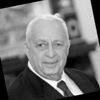

In [7]:
first_image = kept_images[0]
img = keras.preprocessing.image.array_to_img(np.expand_dims(first_image * 255, axis=-1))
display(img)

In [8]:
# remap labels from [0, N - 1]

old_labels_to_new_labels = {}
for label in kept_labels:
    if label not in old_labels_to_new_labels:
        old_labels_to_new_labels[label] = len(old_labels_to_new_labels)

kept_labels = [old_labels_to_new_labels[label] for label in kept_labels]

In [9]:
images = np.expand_dims(np.asarray(kept_images), axis=-1) # necessary to show there is 1 channel (grayscale)?
labels = keras.utils.to_categorical(np.asarray(kept_labels))

In [10]:
print(labels)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [11]:
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
)

In [12]:
datagen.fit(train_images)

In [13]:
train_data_generator = datagen.flow(train_images, train_labels, batch_size=64, shuffle=True)
val_data_generator = datagen.flow(val_images, val_labels, batch_size=64, shuffle=True)

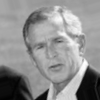

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


In [14]:
# display first image in val data batch and its label -- just for validation
first_batch = next(val_data_generator)
display(keras.preprocessing.image.array_to_img(first_batch[0][0] * 255))
print(first_batch[1][0])

val_data_generator = datagen.flow(val_images, val_labels, batch_size=64, shuffle=True) # reset val_data_generator

In [15]:
# Xception model from https://keras.io/examples/vision/image_classification_from_scratch/#using-image-data-augmentation

# def make_model(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)

#     # Entry block
#     x = layers.Rescaling(1.0 / 255)(inputs)
#     x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     previous_block_activation = x  # Set aside residual

#     for size in [256, 512, 728]:
#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.Activation("relu")(x)
#         x = layers.SeparableConv2D(size, 3, padding="same")(x)
#         x = layers.BatchNormalization()(x)

#         x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

#         # Project residual
#         residual = layers.Conv2D(size, 1, strides=2, padding="same")(
#             previous_block_activation
#         )
#         x = layers.add([x, residual])  # Add back residual
#         previous_block_activation = x  # Set aside next residual

#     x = layers.SeparableConv2D(1024, 3, padding="same")(x)
#     x = layers.BatchNormalization()(x)
#     x = layers.Activation("relu")(x)

#     x = layers.GlobalAveragePooling2D()(x)
#     if num_classes == 2:
#         activation = "sigmoid"
#         units = 1
#     else:
#         activation = "softmax"
#         units = num_classes

#     x = layers.Dropout(0.5)(x)
#     outputs = layers.Dense(units, activation=activation)(x)
#     return keras.Model(inputs, outputs)


# model = make_model(input_shape=IMAGE_SIZE + (1, ), num_classes=len(frequencies))

input_shape = IMAGE_SIZE + (1, )
num_classes = len(set(kept_labels))

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

In [16]:
next(train_data_generator)[1].shape

(64, 12)

In [17]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.legacy.Adam(1e-3), # legacy for m1 support
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_data_generator,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_data_generator,
)

Epoch 1/50


14/14 [==============================] - 5s 309ms/step - loss: 43.4035 - accuracy: 0.1130 - val_loss: 2.4343 - val_accuracy: 0.2000
Epoch 2/50
14/14 [==============================] - 4s 277ms/step - loss: 2.4261 - accuracy: 0.1758 - val_loss: 2.4229 - val_accuracy: 0.1727
Epoch 3/50
14/14 [==============================] - 4s 276ms/step - loss: 2.3554 - accuracy: 0.1849 - val_loss: 2.3608 - val_accuracy: 0.2182
Epoch 4/50
14/14 [==============================] - 4s 272ms/step - loss: 2.3276 - accuracy: 0.2272 - val_loss: 2.3846 - val_accuracy: 0.2091
Epoch 5/50
14/14 [==============================] - 4s 272ms/step - loss: 2.3041 - accuracy: 0.2283 - val_loss: 2.1109 - val_accuracy: 0.2955
Epoch 6/50
14/14 [==============================] - 4s 273ms/step - loss: 2.1846 - accuracy: 0.2546 - val_loss: 2.0455 - val_accuracy: 0.2818
Epoch 7/50
14/14 [==============================] - 4s 286ms/step - loss: 2.0803 - accuracy: 0.2854 - val_loss: 2.2454 - val_accuracy: 0.2773
Epo